<a href="https://colab.research.google.com/github/ritamgh/DLT-lab/blob/main/Week8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === 1. Setup & Kaggle import ===

!pip install kaggle
from google.colab import files
files.upload()  # upload your kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!unzip imdb-dataset-of-50k-movie-reviews.zip -d imdb_data

# List files
!ls imdb_data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
  0% 0.00/25.7M [00:00<?, ?B/s]
100% 25.7M/25.7M [00:00<00:00, 1.60GB/s]
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: imdb_data/IMDB Dataset.csv  
'IMDB Dataset.csv'


In [ ]:
# === 2. Imports & load data ===

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# For reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Load CSV
df = pd.read_csv("imdb_data/IMDB Dataset.csv")  # might be named differently
df.head(), df.shape
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


Null counts:
 review       0
sentiment    0
dtype: int64


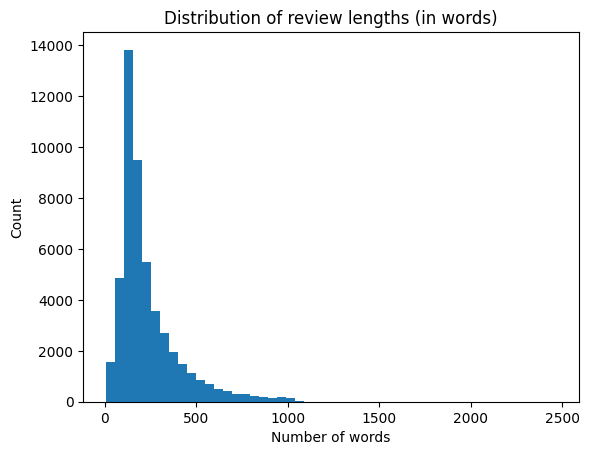

                                                  review sentiment  review_len
33553  I really liked this Summerslam due to the look...  positive         201
9427   Not many television shows appeal to quite as m...  positive         354
199    The film quickly gets to a major chase scene w...  negative         119
12447  Jane Austen would definitely approve of this o...  positive          99
39489  Expectations were somewhat high for me when I ...  negative         332


In [ ]:
# === 3. EDA & basic visualization ===

# Check for missing values
print("Null counts:\n", df.isna().sum())

# Distribution of reviews lengths
df['review_len'] = df['review'].apply(lambda x: len(x.split()))
plt.hist(df['review_len'], bins=50)
plt.title("Distribution of review lengths (in words)")
plt.xlabel("Number of words")
plt.ylabel("Count")
plt.show()

# Example reviews
print(df.sample(5))

In [ ]:
# === 4. Text preprocessing ===

def clean_text(text):
    # lower
    text = text.lower()
    # remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
    # remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # remove extra spaces / digits
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_review'] = df['review'].apply(clean_text)

# After cleaning, inspect
df.head()

,review,sentiment,review_len,clean_review
0,One of the other reviewers has mentioned that ...,positive,307,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,162,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,166,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,138,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,petter matteis love in the time of money is a ...


In [ ]:
# === 5. Tokenization & converting to sequences ===

# Hyperparameters
vocab_size = 20000   # top words
max_len = 200        # max review length (in tokens)
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df['clean_review'])

# Convert to sequences
sequences = tokenizer.texts_to_sequences(df['clean_review'])
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Encode labels (positive / negative) to 1 / 0
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Train / test split
X = padded
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

X_train shape: (40000, 200) X_test shape: (10000, 200)


In [ ]:
# === 6. Build & train RNN model ===

embedding_dim = 128

model_rnn = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    SimpleRNN(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_rnn.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model_rnn.summary()

history_rnn = model_rnn.fit(X_train, y_train,
                            validation_split=0.1,
                            epochs=5,
                            batch_size=128,
                            verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4992 - loss: 0.7002 - val_accuracy: 0.5058 - val_loss: 0.6935
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6000 - loss: 0.6599 - val_accuracy: 0.5005 - val_loss: 0.7178
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5916 - loss: 0.6772 - val_accuracy: 0.5040 - val_loss: 0.7050
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6371 - loss: 0.6014 - val_accuracy: 0.5017 - val_loss: 0.7644
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7026 - loss: 0.5057 - val_accuracy: 0.5035 - val_loss: 0.8700


In [ ]:
# # === 7. Build & train LSTM model ===

# model_lstm = Sequential([
#     Embedding(vocab_size, embedding_dim, input_length=max_len),
#     LSTM(64, return_sequences=False),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

# model_lstm.compile(loss='binary_crossentropy',
#                    optimizer='adam',
#                    metrics=['accuracy'])
# model_lstm.summary()

# history_lstm = model_lstm.fit(X_train, y_train,
#                               validation_split=0.1,
#                               epochs=5,
#                               batch_size=128,
#                               verbose=1)

In [ ]:
# === 8. Evaluation & metrics ===

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob >= 0.5).astype(int)
    print(f"====== {name} results ======")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification report:")
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    # Optionally plot ROC, etc.

print("RNN evaluation:")
evaluate_model(model_rnn, X_test, y_test, name="RNN")

# print("LSTM evaluation:")
# evaluate_model(model_lstm, X_test, y_test, name="LSTM")

RNN evaluation:
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
====== RNN results ======
Accuracy: 0.5115
Classification report:
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      4961
           1       0.52      0.51      0.51      5039

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000

Confusion matrix:
[[2534 2427]
 [2458 2581]]


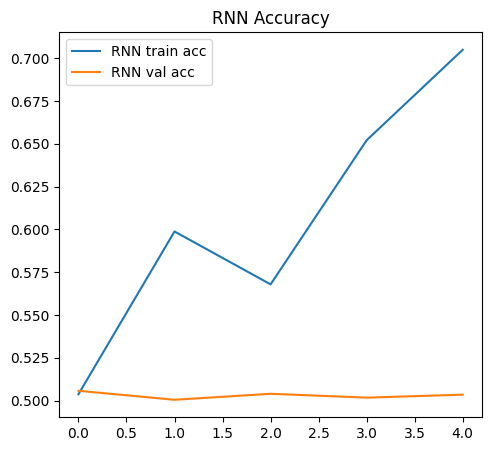

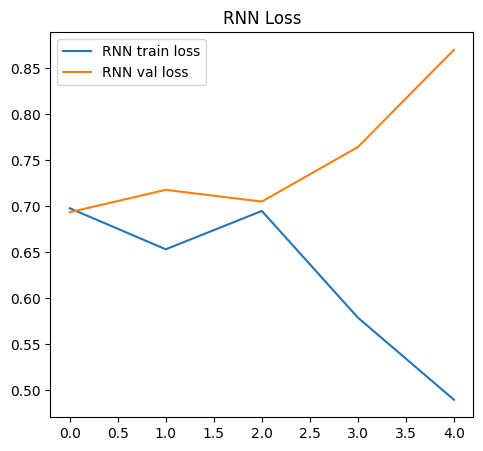

In [ ]:
# === 9. Plot training & validation curves ===

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_rnn.history['accuracy'], label='RNN train acc')
plt.plot(history_rnn.history['val_accuracy'], label='RNN val acc')
plt.title("RNN Accuracy")
plt.legend()

# plt.subplot(1,2,2)
# plt.plot(history_lstm.history['accuracy'], label='LSTM train acc')
# plt.plot(history_lstm.history['val_accuracy'], label='LSTM val acc')
# plt.title("LSTM Accuracy")
# plt.legend()

plt.show()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_rnn.history['loss'], label='RNN train loss')
plt.plot(history_rnn.history['val_loss'], label='RNN val loss')
plt.title("RNN Loss")
plt.legend()

# plt.subplot(1,2,2)
# plt.plot(history_lstm.history['loss'], label='LSTM train loss')
# plt.plot(history_lstm.history['val_loss'], label='LSTM val loss')
# plt.title("LSTM Loss")
# plt.legend()

plt.show()